# Figure S7

### Import packages

In [1]:
%load_ext nb_black

import scdiffeq as sdq
import dev
import cellplots as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import ABCParse
import os
import pathlib
import seaborn as sns
import larry
import scipy.stats
import glob
import matplotlib

<IPython.core.display.Javascript object>

### Read data and load project

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

In [3]:
project = sdq.io.Project(path="./LightningSDE-FixedPotential-RegularizedVelocityRatio/")

<IPython.core.display.Javascript object>

### Compute fate prediction accuracy for each version

In [4]:
RATIOS = {}
for version, path in project._VERSION_PATHS.items():
    try:
        v = getattr(project, version)
        acc = dev.fate_prediction_accuracy(v)
        target_ratio = v.hparams["velocity_ratio_params"]["target"]
        RATIOS[version] = target_ratio, v, acc
    except:
        pass

<IPython.core.display.Javascript object>

### For each un-regularized training run, compute drift [`f`] and diffusion [`g`]

In [5]:
def f(df, key="training"):
    return df.filter(regex="velo_f").filter(regex=key).dropna().sum(1).mean()


def g(df, key="training"):
    return df.filter(regex="velo_g").filter(regex=key).dropna().sum(1).mean()


UnEnforcedResults = {}
for en, (version, results) in enumerate(RATIOS.items()):
    target_ratio, v, acc = results
    if v.hparams["velocity_ratio_params"]["enforce"] == 0:
        print(version)
        grouped = v.metrics_df.groupby("epoch")
        UnEnforcedResults[version] = {
            "f_training": grouped.apply(f, key="training"),
            "f_validation": grouped.apply(f, key="validation"),
            "g_training": grouped.apply(g, key="training"),
            "g_validation": grouped.apply(g, key="validation"),
        }

version_0
version_1
version_2
version_3
version_4


<IPython.core.display.Javascript object>

### Compute the empirical unenforced ratio

In [6]:
unenforced_ratio = np.array(
    [
        v["f_validation"].iloc[-1] / v["g_validation"].iloc[-1]
        for i, (k, v) in enumerate(UnEnforcedResults.items())
    ]
)
unenforced_ratio.mean(), unenforced_ratio.std()

(0.3669882612570243, 0.13488926187436895)

<IPython.core.display.Javascript object>

In [7]:
rel = unenforced_ratio / (1 + unenforced_ratio)
print(rel.mean(), rel.std())
print(unenforced_ratio.mean() / (1 + unenforced_ratio.mean()))

0.26198354528285633 0.06584885182554004
0.2684648227480443


<IPython.core.display.Javascript object>

In [8]:
OrgResults = {}
for en, (version, results) in enumerate(RATIOS.items()):
    target_ratio, v, acc = results
    if v.hparams["velocity_ratio_params"]["enforce"] == 0:
        target_ratio = unenforced_ratio.mean()  # 0.3669882612570243
    if not target_ratio in OrgResults.keys():
        OrgResults[target_ratio] = []
    best = acc[acc.loc["unique_train.all_fates"].idxmax()]["unique_test.all_fates"]
    OrgResults[target_ratio].append(best)

<IPython.core.display.Javascript object>

In [9]:
sorted_results = {
    key: OrgResults[key]
    for key in sorted(np.array(list(OrgResults.keys())).astype(float))
}

<IPython.core.display.Javascript object>

In [10]:
for k, v in sorted_results.items():
    print("{:>9.4f} {:.3f}  {:.4f} | {}".format(k, np.mean(v), np.std(v), len(v)))

   0.0010 0.523  0.0164 | 5
   0.0100 0.499  0.0253 | 5
   0.3670 0.513  0.0271 | 5
   0.5000 0.520  0.0320 | 5
   1.0000 0.530  0.0160 | 5
   1.5000 0.506  0.0154 | 5
   2.2500 0.529  0.0386 | 5
   2.5000 0.548  0.0260 | 5
   3.0000 0.522  0.0381 | 5
   5.0000 0.530  0.0157 | 5
  10.0000 0.523  0.0347 | 5
  20.0000 0.391  0.0713 | 5
  30.0000 0.292  0.0467 | 4


<IPython.core.display.Javascript object>

In [11]:
F_obs = larry.tasks.fate_prediction.F_obs

<IPython.core.display.Javascript object>

In [15]:
def _test_from_best_train(acc):
    best_train_epoch = acc.loc["unique_train.all_fates"].idxmax()
    best_train = acc[best_train_epoch]
    return best_train_epoch, best_train["unique_test.all_fates"]


def _get_best_F_hat_path(version, best_epoch):
    """use glob to filter and grab the right saved F_hat"""
    try:
        regex = f"LightningSDE-FixedPotential-RegularizedVelocityRatio/version_{version}/fate_prediction_metrics/{best_epoch}*/F_hat.processed.csv"
        return glob.glob(regex)[0]
    except:
        regex = f"LightningSDE-FixedPotential-RegularizedVelocityRatio/version_{version}/fate_prediction_metrics/on_train_end*/F_hat.processed.csv"
        print(regex)
        return glob.glob(regex)[0]


def _convert_best_epoch_name(row):
    if row["best_epoch"] == 2500:
        return "last"
    if row["best_epoch"] == 2499:
        return "on_train_end"
    return f"epoch_{row['best_epoch']}"


def get_best_results(RATIOS):
    BestResults = []
    for en, (version, results) in enumerate(RATIOS.items()):
        if not version in ["version_46", "version_71"]:

            target_ratio, v, acc = results
            #             if target_ratio == 30:
            #                 print(acc)
            #                 print()
            #         if not str(target_ratio) in OrgResults.keys():
            #             BestResults[] = []

            best_epoch, best_score = _test_from_best_train(acc)
            v_key = version.split("version_")[-1]
            BestResults.append(
                {
                    "target_ratio": str(target_ratio),
                    "best_epoch": best_epoch,
                    "best_score": best_score,
                    "version": v_key,
                }
            )

    return pd.DataFrame(BestResults)

<IPython.core.display.Javascript object>

In [16]:
best_results = get_best_results(RATIOS)
best_results

,target_ratio,best_epoch,best_score,version
0,2.0,1891,0.508731,0
1,2.0,2500,0.485448,1
2,5.0,2285,0.522701,10
3,0.01,1674,0.472643,11
4,1.0,1294,0.552969,12
...,...,...,...,...
58,2.25,1603,0.516880,62
59,2.25,2285,0.477299,63
60,5.0,1330,0.514552,7
61,5.0,1119,0.555297,8


<IPython.core.display.Javascript object>

In [17]:
def get_grouped_F_hat_dfs(group_df):
    GroupF_hats = []
    for i, row in group_df.iterrows():
        #         print(row)
        F_hat_path = _get_best_F_hat_path(
            version=row["version"], best_epoch=_convert_best_epoch_name(row)
        )
        F_hat = pd.read_csv(F_hat_path, index_col=0)
        GroupF_hats.append(F_hat)
    return GroupF_hats

<IPython.core.display.Javascript object>

In [18]:
best_F_hats = (
    best_results.groupby("target_ratio").apply(get_grouped_F_hat_dfs).to_dict()
)

LightningSDE-FixedPotential-RegularizedVelocityRatio/version_50/fate_prediction_metrics/on_train_end*/F_hat.processed.csv


<IPython.core.display.Javascript object>

In [19]:
Entropy = {}
for key, val in best_F_hats.items():
    Entropy[key] = [scipy.stats.entropy(F_hat, axis=1) for F_hat in val]

MeanStdEntropy = {}
for en, (k, v) in enumerate(Entropy.items()):
    y = np.array(v).flatten()
    y = y[np.isfinite(y)]
    MeanStdEntropy[en] = {"vR": float(k), "mean": y.mean(), "std": y.std()}
entropy = pd.DataFrame(MeanStdEntropy).T
entropy = entropy.sort_values("vR").reset_index(drop=True)
entropy

,vR,mean,std
0,0.001,0.738279,0.361552
1,0.010,0.762121,0.391919
2,0.500,0.549093,0.370522
3,1.000,0.503532,0.374606
4,1.500,0.486654,0.380101
5,2.000,0.582116,0.397537
6,2.250,0.431386,0.363275
7,2.500,0.354065,0.373081
8,3.000,0.368025,0.403702
9,5.000,0.340746,0.377944


<IPython.core.display.Javascript object>

In [21]:
mean_obs_entropy = scipy.stats.entropy(F_obs, axis=1).mean()

<IPython.core.display.Javascript object>

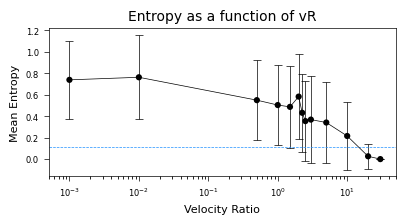

<IPython.core.display.Javascript object>

In [23]:
fig, axes = cp.plot(
    height=0.4,
    width=0.7,
    title=["Entropy as a function of vR"],
    x_label=["Velocity Ratio"],
    y_label=["Mean Entropy"],
)
axes[0].set_xscale("log")
[x.set_linewidth(0.5) for x in axes[0].spines.values()]
axes[0].xaxis.set_tick_params(width=0.5)
axes[0].yaxis.set_tick_params(width=0.5)
# axes[0].plot(mean_std_entropy["R"], mean_std_entropy["mean"], color="k", lw = 0.5)
axes[0].scatter(entropy["vR"], entropy["mean"], s=20, c="k", ec="None")
axes[0].errorbar(
    entropy["vR"],
    entropy["mean"],
    lw=0.5,
    yerr=entropy["std"],
    capsize=3,
    capthick=0.5,
    elinewidth=0.5,
    color="k",
)
plt.xlim(0.0005, 50)
axes[0].hlines(
    y=mean_obs_entropy, xmin=0.0005, xmax=50, color="dodgerblue", ls="--", lw=0.5
)
plt.savefig("entropy_function_of_velo_ratio.fig_s7.svg")